In [1]:
!pip install transformers datasets scikit-learn matplotlib seaborn --quiet


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
!pip install hf_transfer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 54.5 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


Total Sample Size: 1600000 (Balanced Positive, Negative)
Using Device: GPU


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


Using Batch Size: 128
Starting batch predictions...
Processed 0 / 1600000 samples...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processed 12800 / 1600000 samples...
Processed 25600 / 1600000 samples...
Processed 38400 / 1600000 samples...
Processed 51200 / 1600000 samples...
Processed 64000 / 1600000 samples...
Processed 76800 / 1600000 samples...
Processed 89600 / 1600000 samples...
Processed 102400 / 1600000 samples...
Processed 115200 / 1600000 samples...
Processed 128000 / 1600000 samples...
Processed 140800 / 1600000 samples...
Processed 153600 / 1600000 samples...
Processed 166400 / 1600000 samples...
Processed 179200 / 1600000 samples...
Processed 192000 / 1600000 samples...
Processed 204800 / 1600000 samples...
Processed 217600 / 1600000 samples...
Processed 230400 / 1600000 samples...
Processed 243200 / 1600000 samples...
Processed 256000 / 1600000 samples...
Processed 268800 / 1600000 samples...
Processed 281600 / 1600000 samples...
Processed 294400 / 1600000 samples...
Processed 307200 / 1600000 samples...
Processed 320000 / 1600000 samples...
Processed 332800 / 1600000 samples...
Processed 345600 / 

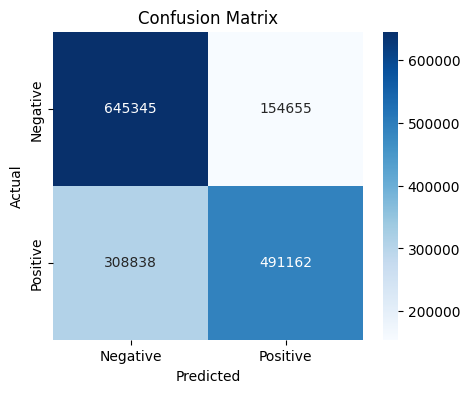

In [3]:
# Step 1: Install Dependencies (Uncomment if needed)
# !pip install datasets transformers scikit-learn matplotlib seaborn

# Step 2: Load and Prepare the Full Balanced Dataset
import pandas as pd

# Path to your Sentiment140 CSV
path="training.1600000.processed.noemoticon.csv"

# Correct column names from dataset description
cols = ["sentiment", "id", "date", "flag", "user", "text"]

# Load CSV using correct encoding and no header
df = pd.read_csv(path, encoding="latin-1", header=None, names=cols)

# Keep only Positive (4) and Negative (0) sentiments
df = df[df['sentiment'].isin([0, 4])].reset_index(drop=True)
df['label'] = df['sentiment'].map({0: 0, 4: 1})  # 0: Negative, 1: Positive

# Shuffle the dataset
sample_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

texts = sample_df['text'].tolist()
true_labels = sample_df['label'].tolist()

print(f"Total Sample Size: {len(texts)} (Balanced Positive, Negative)")

# Step 3: Load Pretrained Model with Automatic GPU Acceleration
import torch
from transformers import pipeline

device = 0 if torch.cuda.is_available() else -1
print(f"Using Device: {'GPU' if device == 0 else 'CPU'}")

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, device=device)

# Step 4: Dynamically Set Batch Size Based on VRAM (if GPU is available)
if device == 0:
    vram_gb = torch.cuda.get_device_properties(0).total_memory // (1024**3)
    if vram_gb >= 24:
        batch_size = 128
    elif vram_gb >= 16:
        batch_size = 64
    else:
        batch_size = 32
else:
    batch_size = 16  # Lower batch size for CPU to avoid memory issues

print(f"Using Batch Size: {batch_size}")

# Step 5: Predict in Batches and Time the Inference
import time
pred_labels = []

start_time = time.time()

print("Starting batch predictions...")
for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]
    predictions = sentiment_pipeline(batch_texts, truncation=True, batch_size=batch_size)
    batch_preds = [0 if p['label'] == 'NEGATIVE' else 1 for p in predictions]
    pred_labels.extend(batch_preds)
    if (i // batch_size) % 100 == 0:
        print(f"Processed {i} / {len(texts)} samples...")

end_time = time.time()
print(f"Total Inference Time: {end_time - start_time:.2f} seconds")

# Step 6: Compute Errors and Report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, pred_labels)
tn, fp, fn, tp = cm.ravel()

fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
total_error = (fp + fn) / len(true_labels)
accuracy = (tp + tn) / len(true_labels)

print(f"\nError Analysis:")
print(f"Accuracy: {accuracy:.2%}")
print(f"False Positive Rate (FPR): {fpr:.2%}")
print(f"False Negative Rate (FNR): {fnr:.2%}")
print(f"Total Error Rate: {total_error:.2%}")

# Step 7: Visualize Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
             xticklabels=['Negative', 'Positive'],
             yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [4]:
## LOADING DATA
import pandas as pd
import torch
from collections import Counter
# Path to your Sentiment140 CSV
path="training.1600000.processed.noemoticon.csv"

# Correct column names from dataset description
cols = ["sentiment", "id", "date", "flag", "user", "text"]

# Load CSV using correct encoding and no header
df = pd.read_csv(path, encoding="latin-1", header=None, names=cols)
# Keep only Positive (4) and Negative (0) sentiments
df = df[df['sentiment'].isin([0, 4])].reset_index(drop=True)
df['label'] = df['sentiment'].map({0: 0, 4: 1})

# Ensure balanced dataset
min_class_count = min(df['label'].value_counts()[0], df['label'].value_counts()[1])
pos_samples = df[df['label'] == 1].sample(min_class_count, random_state=42)
neg_samples = df[df['label'] == 0].sample(min_class_count, random_state=42)
balanced_df = pd.concat([pos_samples, neg_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

texts = balanced_df['text'].tolist()
labels = balanced_df['label'].tolist()

print(f"Total Sample Size: {len(texts)} (Balanced Positive, Negative)")

# Step 3: Tokenization and Data Preparation
from collections import Counter
from torch.utils.data import Dataset, DataLoader

tokenized_texts = [text.lower().split() for text in texts]
all_words = [word for text in tokenized_texts for word in text]
vocab = {word: idx + 1 for idx, (word, _) in enumerate(Counter(all_words).most_common(10000))}
vocab['<PAD>'] = 0

def encode(text, max_len=50):
    ids = [vocab.get(word, 0) for word in text]
    ids = ids[:max_len] + [0] * (max_len - len(ids))
    return ids

encoded_texts = [encode(text) for text in tokenized_texts]

# Balanced Split: 80% Train, 10% Validation, 10% Test
total_samples = len(encoded_texts)
train_end = int(0.8 * total_samples)
val_end = int(0.9 * total_samples)

X_train = encoded_texts[:train_end]
y_train = labels[:train_end]

X_val = encoded_texts[train_end:val_end]
y_val = labels[train_end:val_end]

X_test = encoded_texts[val_end:]
y_test = labels[val_end:]

print(f"Train Size: {len(X_train)}")
print(f"Validation Size: {len(X_val)}")
print(f"Test Size: {len(X_test)}")

class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
print(f"Using Batch Size: {batch_size}")

train_ds = SentimentDataset(X_train, y_train)
val_ds = SentimentDataset(X_val, y_val)
test_ds = SentimentDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

Total Sample Size: 1600000 (Balanced Positive, Negative)
Train Size: 1280000
Validation Size: 160000
Test Size: 160000
Using Batch Size: 32


In [5]:
# Define CNN Models
import torch.nn as nn
import torch.nn.functional as F

# Baseline CNN (given version)
class CNNBaseline(nn.Module):
    def __init__(self, vocab_size, embed_dim=100):
        super(CNNBaseline, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=5)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = self.pool(x).squeeze(2)
        x = self.fc(x).squeeze(1)
        return torch.sigmoid(x)

# Modified CNN (assignment requirement)
class CNNModified(nn.Module):
    def __init__(self, vocab_size, embed_dim=100):
        super(CNNModified, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv1d(embed_dim, 256, kernel_size=7)
        self.conv2 = nn.Conv1d(256, 256, kernel_size=5)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).squeeze(2)
        x = self.fc(x).squeeze(1)
        return torch.sigmoid(x)


In [6]:
# Training Function with Validation Monitoring
import time

def train_model(model, learning_rate):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    best_val_loss = float("inf")
    patience = 3

    for epoch in range(20):
        model.train()
        total_loss = 0
        start_time = time.time()

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        end_time = time.time()

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                val_loss += loss.item()

                predicted = (preds > 0.5).int()
                correct += (predicted == y_batch.int()).sum().item()
                total += y_batch.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_error_rate = 1 - (correct / total)

        print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Error Rate: {val_error_rate:.2%}, "
              f"Time: {end_time - start_time:.2f}s")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = model.state_dict()
            patience = 3
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_state)
    return model


In [7]:
# Evaluation Function

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 7: Evaluation Function (Returns Accuracy)
def evaluate(model, loader, dataset_name="Test"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            preds = model(X_batch)
            preds = (preds > 0.5).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    total_error = (fp + fn) / len(all_labels)
    accuracy = 1 - total_error

    print(f"\n{dataset_name} Set Error Analysis:")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"False Positive Rate (FPR): {fpr:.2%}")
    print(f"False Negative Rate (FNR): {fnr:.2%}")
    print(f"Total Error Rate: {total_error:.2%}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=['Negative', 'Positive'],
                 yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    return accuracy 


# Step 8: Count Parameters (YOUR EXACT FUNCTION)
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")


========== BASELINE CNN | LR = 0.001 ==========
Epoch 1, Train Loss: 0.6178, Val Loss: 0.5781, Val Error Rate: 30.59%, Time: 195.53s
Epoch 2, Train Loss: 0.5554, Val Loss: 0.5400, Val Error Rate: 27.49%, Time: 196.13s
Epoch 3, Train Loss: 0.5259, Val Loss: 0.5217, Val Error Rate: 26.00%, Time: 194.70s
Epoch 4, Train Loss: 0.5083, Val Loss: 0.5090, Val Error Rate: 25.06%, Time: 189.99s
Epoch 5, Train Loss: 0.4960, Val Loss: 0.5022, Val Error Rate: 24.60%, Time: 181.07s
Epoch 6, Train Loss: 0.4867, Val Loss: 0.4972, Val Error Rate: 24.32%, Time: 161.64s
Epoch 7, Train Loss: 0.4793, Val Loss: 0.4930, Val Error Rate: 23.95%, Time: 147.45s
Epoch 8, Train Loss: 0.4733, Val Loss: 0.4902, Val Error Rate: 23.78%, Time: 198.93s
Epoch 9, Train Loss: 0.4681, Val Loss: 0.4877, Val Error Rate: 23.64%, Time: 208.20s
Epoch 10, Train Loss: 0.4636, Val Loss: 0.4866, Val Error Rate: 23.46%, Time: 202.87s
Epoch 11, Train Loss: 0.4596, Val Loss: 0.4840, Val Error Rate: 23.32%, Time: 202.82s
Epoch 12, Trai

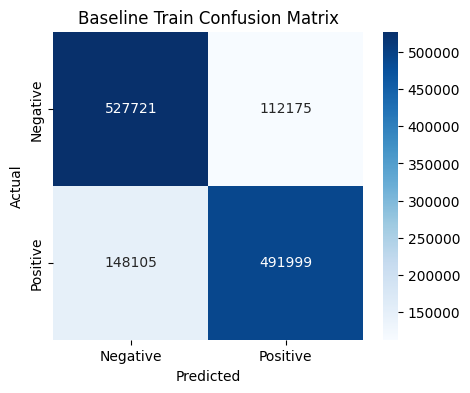


Baseline Val Set Error Analysis:
Accuracy: 76.89%
False Positive Rate (FPR): 20.42%
False Negative Rate (FNR): 25.82%
Total Error Rate: 23.11%


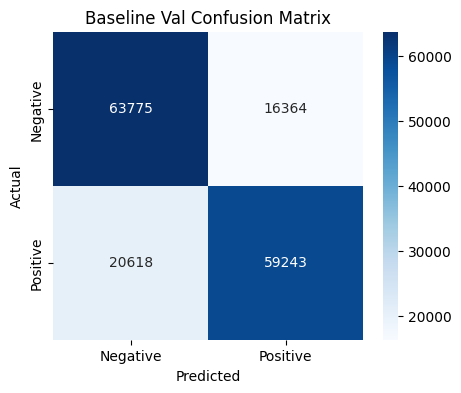


Baseline Test Set Error Analysis:
Accuracy: 76.81%
False Positive Rate (FPR): 20.49%
False Negative Rate (FNR): 25.88%
Total Error Rate: 23.19%


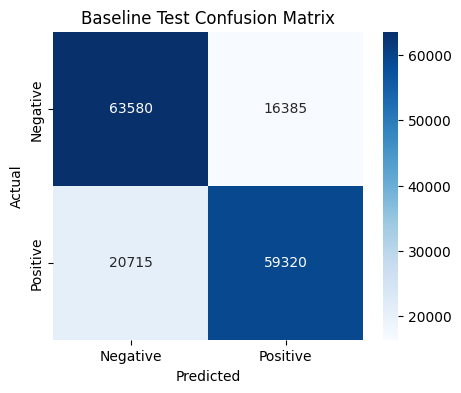


Baseline Model Parameters:
Total Parameters: 1,064,357
Trainable Parameters: 1,064,357

========== MODIFIED CNN | LR = 0.001 ==========
Epoch 1, Train Loss: 0.6497, Val Loss: 0.6161, Val Error Rate: 34.23%, Time: 232.87s
Epoch 2, Train Loss: 0.5977, Val Loss: 0.5777, Val Error Rate: 30.55%, Time: 219.77s
Epoch 3, Train Loss: 0.5593, Val Loss: 0.5464, Val Error Rate: 27.93%, Time: 221.01s
Epoch 4, Train Loss: 0.5302, Val Loss: 0.5237, Val Error Rate: 26.16%, Time: 191.70s
Epoch 5, Train Loss: 0.5097, Val Loss: 0.5124, Val Error Rate: 25.32%, Time: 229.58s
Epoch 6, Train Loss: 0.4939, Val Loss: 0.5037, Val Error Rate: 24.74%, Time: 234.30s
Epoch 7, Train Loss: 0.4809, Val Loss: 0.4945, Val Error Rate: 24.19%, Time: 231.79s
Epoch 8, Train Loss: 0.4697, Val Loss: 0.4902, Val Error Rate: 23.88%, Time: 238.88s
Epoch 9, Train Loss: 0.4598, Val Loss: 0.4937, Val Error Rate: 24.13%, Time: 231.43s
Epoch 10, Train Loss: 0.4507, Val Loss: 0.4841, Val Error Rate: 23.47%, Time: 218.36s
Epoch 11, Tr

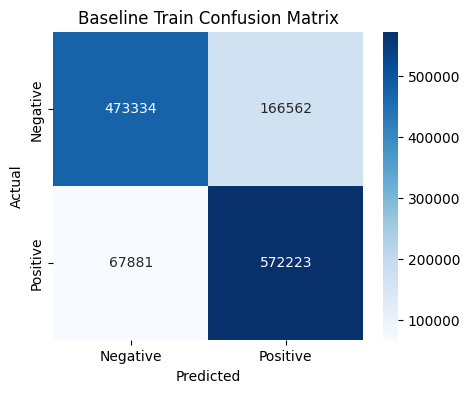


Baseline Val Set Error Analysis:
Accuracy: 76.22%
False Positive Rate (FPR): 31.71%
False Negative Rate (FNR): 15.83%
Total Error Rate: 23.78%


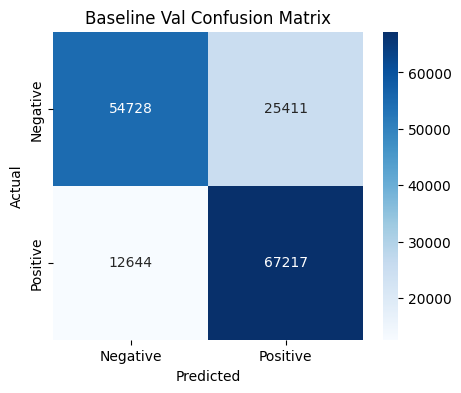


Baseline Test Set Error Analysis:
Accuracy: 76.19%
False Positive Rate (FPR): 31.93%
False Negative Rate (FNR): 15.69%
Total Error Rate: 23.81%


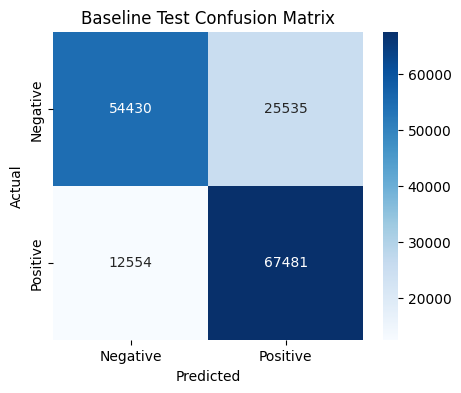


Modified Model Parameters:
Total Parameters: 1,507,749
Trainable Parameters: 1,507,749

========== BASELINE CNN | LR = 0.01 ==========
Epoch 1, Train Loss: 0.5387, Val Loss: 0.5038, Val Error Rate: 24.95%, Time: 191.54s
Epoch 2, Train Loss: 0.4890, Val Loss: 0.4877, Val Error Rate: 23.57%, Time: 160.09s
Epoch 3, Train Loss: 0.4723, Val Loss: 0.4831, Val Error Rate: 23.29%, Time: 170.30s
Epoch 4, Train Loss: 0.4620, Val Loss: 0.4776, Val Error Rate: 22.86%, Time: 199.97s
Epoch 5, Train Loss: 0.4544, Val Loss: 0.4755, Val Error Rate: 22.76%, Time: 194.91s
Epoch 6, Train Loss: 0.4487, Val Loss: 0.4733, Val Error Rate: 22.57%, Time: 185.56s
Epoch 7, Train Loss: 0.4438, Val Loss: 0.5168, Val Error Rate: 24.91%, Time: 187.87s
Epoch 8, Train Loss: 0.4398, Val Loss: 0.4750, Val Error Rate: 22.62%, Time: 191.27s
Epoch 9, Train Loss: 0.4362, Val Loss: 0.4742, Val Error Rate: 22.45%, Time: 184.56s
Early stopping triggered.

Baseline Train Set Error Analysis:
Accuracy: 80.97%
False Positive Rate 

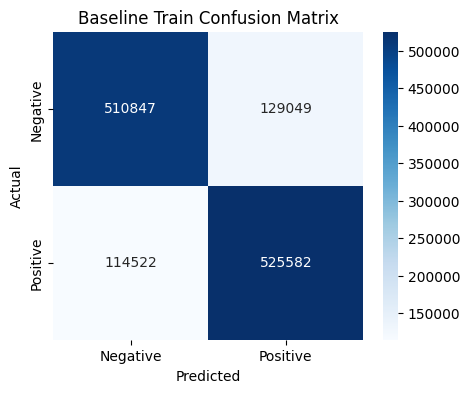


Baseline Val Set Error Analysis:
Accuracy: 77.55%
False Positive Rate (FPR): 23.56%
False Negative Rate (FNR): 21.33%
Total Error Rate: 22.45%


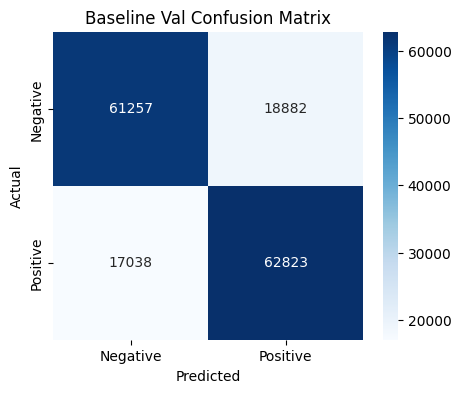


Baseline Test Set Error Analysis:
Accuracy: 77.62%
False Positive Rate (FPR): 23.53%
False Negative Rate (FNR): 21.23%
Total Error Rate: 22.38%


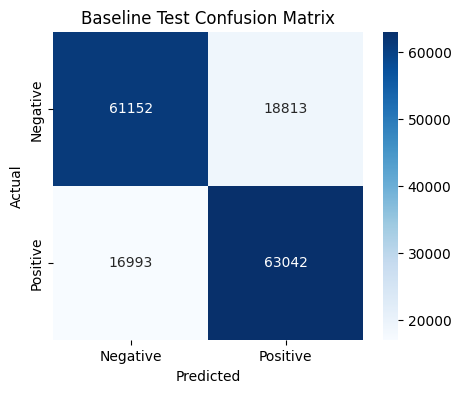


Baseline Model Parameters:
Total Parameters: 1,064,357
Trainable Parameters: 1,064,357

========== MODIFIED CNN | LR = 0.01 ==========
Epoch 1, Train Loss: 0.5545, Val Loss: 0.4967, Val Error Rate: 24.32%, Time: 214.03s
Epoch 2, Train Loss: 0.4783, Val Loss: 0.4726, Val Error Rate: 22.82%, Time: 194.21s
Epoch 3, Train Loss: 0.4469, Val Loss: 0.4700, Val Error Rate: 22.62%, Time: 228.06s
Epoch 4, Train Loss: 0.4239, Val Loss: 0.4673, Val Error Rate: 22.21%, Time: 221.60s
Epoch 5, Train Loss: 0.4041, Val Loss: 0.4705, Val Error Rate: 22.26%, Time: 227.48s
Epoch 6, Train Loss: 0.3854, Val Loss: 0.4757, Val Error Rate: 22.32%, Time: 230.16s
Epoch 7, Train Loss: 0.3681, Val Loss: 0.5091, Val Error Rate: 23.00%, Time: 219.89s
Early stopping triggered.

Baseline Train Set Error Analysis:
Accuracy: 85.22%
False Positive Rate (FPR): 9.51%
False Negative Rate (FNR): 20.05%
Total Error Rate: 14.78%


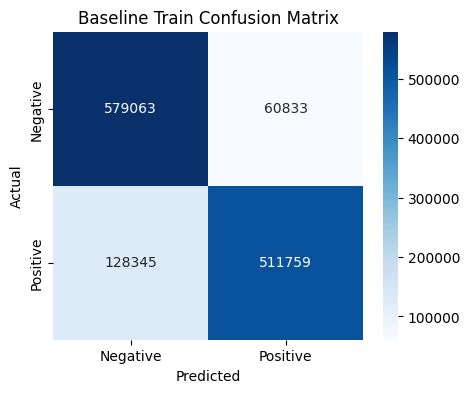


Baseline Val Set Error Analysis:
Accuracy: 77.00%
False Positive Rate (FPR): 16.98%
False Negative Rate (FNR): 29.04%
Total Error Rate: 23.00%


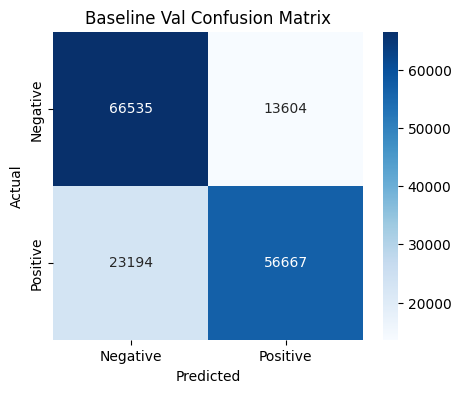


Baseline Test Set Error Analysis:
Accuracy: 77.14%
False Positive Rate (FPR): 16.79%
False Negative Rate (FNR): 28.92%
Total Error Rate: 22.86%


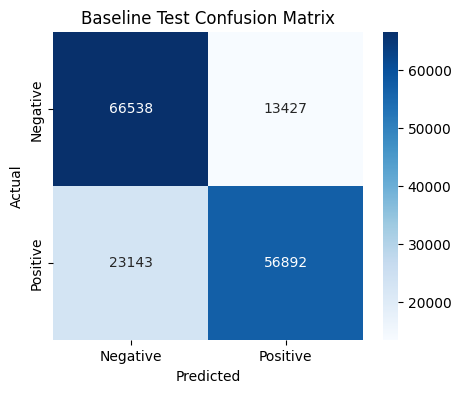


Modified Model Parameters:
Total Parameters: 1,507,749
Trainable Parameters: 1,507,749

========== BASELINE CNN | LR = 0.1 ==========
Epoch 1, Train Loss: 0.5576, Val Loss: 0.5164, Val Error Rate: 24.99%, Time: 173.33s
Epoch 2, Train Loss: 0.5071, Val Loss: 0.5129, Val Error Rate: 23.96%, Time: 153.41s
Epoch 3, Train Loss: 0.4869, Val Loss: 0.4885, Val Error Rate: 23.07%, Time: 171.45s
Epoch 4, Train Loss: 0.4742, Val Loss: 0.4796, Val Error Rate: 22.48%, Time: 196.88s
Epoch 5, Train Loss: 0.4644, Val Loss: 0.4873, Val Error Rate: 22.60%, Time: 194.09s
Epoch 6, Train Loss: 0.4570, Val Loss: 0.4805, Val Error Rate: 22.53%, Time: 194.46s
Epoch 7, Train Loss: 0.4508, Val Loss: 0.4768, Val Error Rate: 21.76%, Time: 196.34s
Epoch 8, Train Loss: 0.4452, Val Loss: 0.4737, Val Error Rate: 21.62%, Time: 193.52s
Epoch 9, Train Loss: 0.4406, Val Loss: 0.4774, Val Error Rate: 21.78%, Time: 179.17s
Epoch 10, Train Loss: 0.4361, Val Loss: 0.4818, Val Error Rate: 21.79%, Time: 184.87s
Epoch 11, Trai

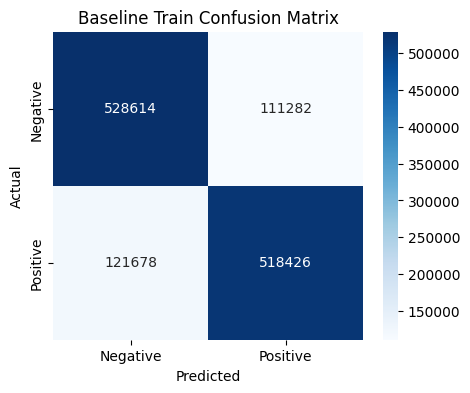


Baseline Val Set Error Analysis:
Accuracy: 78.09%
False Positive Rate (FPR): 20.94%
False Negative Rate (FNR): 22.88%
Total Error Rate: 21.91%


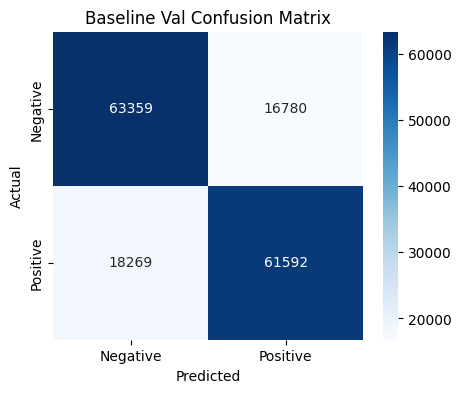


Baseline Test Set Error Analysis:
Accuracy: 78.14%
False Positive Rate (FPR): 21.17%
False Negative Rate (FNR): 22.54%
Total Error Rate: 21.86%


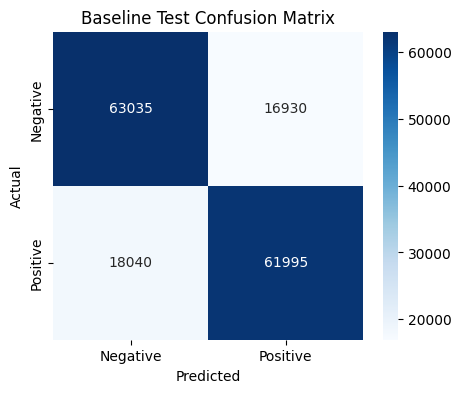


Baseline Model Parameters:
Total Parameters: 1,064,357
Trainable Parameters: 1,064,357

========== MODIFIED CNN | LR = 0.1 ==========
Epoch 1, Train Loss: 0.5294, Val Loss: 0.4912, Val Error Rate: 23.60%, Time: 218.85s
Epoch 2, Train Loss: 0.4667, Val Loss: 0.4634, Val Error Rate: 21.89%, Time: 216.77s
Epoch 3, Train Loss: 0.4420, Val Loss: 0.4640, Val Error Rate: 21.63%, Time: 214.32s
Epoch 4, Train Loss: 0.4232, Val Loss: 0.4639, Val Error Rate: 21.75%, Time: 204.32s
Epoch 5, Train Loss: 0.4074, Val Loss: 0.4797, Val Error Rate: 22.40%, Time: 215.52s
Early stopping triggered.

Baseline Train Set Error Analysis:
Accuracy: 83.25%
False Positive Rate (FPR): 23.63%
False Negative Rate (FNR): 9.86%
Total Error Rate: 16.75%


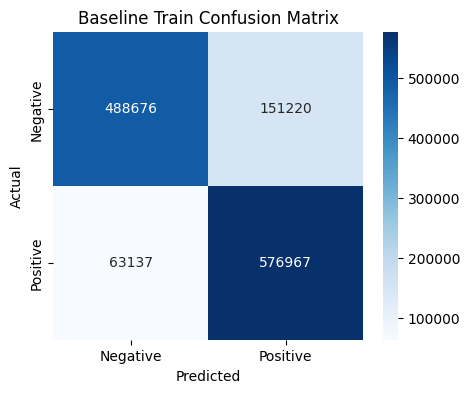


Baseline Val Set Error Analysis:
Accuracy: 77.60%
False Positive Rate (FPR): 29.59%
False Negative Rate (FNR): 15.19%
Total Error Rate: 22.40%


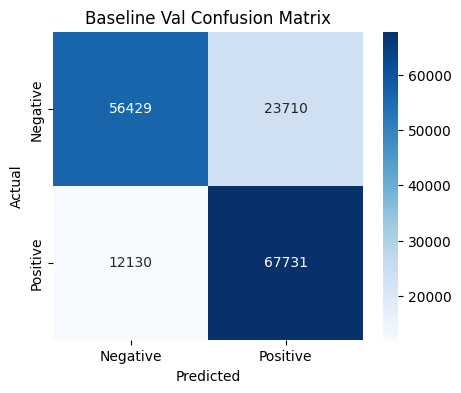


Baseline Test Set Error Analysis:
Accuracy: 77.59%
False Positive Rate (FPR): 29.69%
False Negative Rate (FNR): 15.13%
Total Error Rate: 22.41%


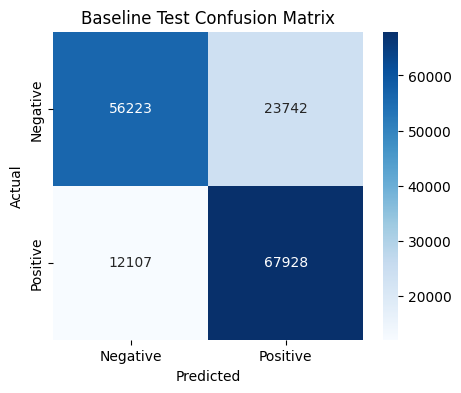


Modified Model Parameters:
Total Parameters: 1,507,749
Trainable Parameters: 1,507,749

==================== FINAL RESULTS TABLE ====================

       Model  Learning Rate  Train Accuracy  Validation Accuracy  Test Accuracy
Baseline CNN          0.001        0.796656             0.768863       0.768125
Modified CNN          0.001        0.816841             0.762156       0.761944
Baseline CNN          0.010        0.809710             0.775500       0.776212
Modified CNN          0.010        0.852205             0.770012       0.771437
Baseline CNN          0.100        0.818000             0.780944       0.781438
Modified CNN          0.100        0.832534             0.776000       0.775944


In [10]:
# Run All Experiments Required by Assignment

learning_rates = [0.001, 0.01, 0.1]
results = []

for lr in learning_rates:

    # BASELINE
    print(f"\n========== BASELINE CNN | LR = {lr} ==========")
    base_model = CNNBaseline(len(vocab))
    base_model = train_model(base_model, lr)
    
    train_acc = evaluate(base_model, train_loader, dataset_name="Baseline Train")
    val_acc = evaluate(base_model, val_loader, dataset_name="Baseline Val")
    test_acc = evaluate(base_model, test_loader, dataset_name="Baseline Test")

    print("\nBaseline Model Parameters:")
    count_parameters(base_model)

    results.append({
        "Model": "Baseline CNN",
        "Learning Rate": lr,
        "Train Accuracy":train_acc,
        "Validation Accuracy":val_acc,
        "Test Accuracy": test_acc
    })

    # MODIFIED
    print(f"\n========== MODIFIED CNN | LR = {lr} ==========")
    mod_model = CNNModified(len(vocab))
    mod_model = train_model(mod_model, lr)
    
    train_acc = evaluate(mod_model, train_loader, dataset_name="Baseline Train")
    val_acc = evaluate(mod_model, val_loader, dataset_name="Baseline Val")
    test_acc = evaluate(mod_model, test_loader, dataset_name="Baseline Test")
    

    print("\nModified Model Parameters:")
    count_parameters(mod_model)

    results.append({
        "Model": "Modified CNN",
        "Learning Rate": lr,
        "Train Accuracy":train_acc,
        "Validation Accuracy":val_acc,
        "Test Accuracy": test_acc
    })

# FINAL RESULTS TABLE
df_results = pd.DataFrame(results)
print("\n==================== FINAL RESULTS TABLE ====================\n")
print(df_results.to_string(index=False))

Vocabulary Size (including <PAD>): 10001


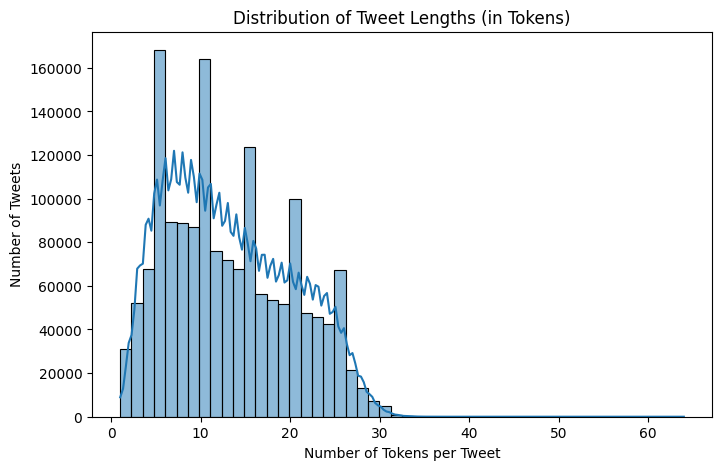

Average Tweet Length (in tokens): 13.18
Median Tweet Length (in tokens): 12.0
Max Tweet Length (in tokens): 64
Min Tweet Length (in tokens): 1
Tweets Exceeding Max Sequence Length (50 tokens): 3 (0.00%)

Sample Positive Tweets:
1. whoo the party was funfunfun!  had a great time.
2. Playing with new strings 
3. guess who's birthday is tomorrow!  oh probably the same girl who's best friend is getting home tomorrow...woooooooo 
4. @Huynhtmx looool sike... 1 more year Maria one more year! 
5. just what every businessman needs most  ? http://blip.fm/~4mfxr
6. @davidismyangel omg Sirius!!  i love when you find out he's innocent!
7. just played 500 i won 625 ) YAY ME 
8. @amymphillips   welcome to twitter ames.. my original &quot;welcome to twitter&quot; had too many L's in your last name 
9. is loving Look How I'm Doing, Heidi Montags new song  can't wait for the album Heidi!
10. @aschmitt hummm a little legal problem  if I recall  http://bit.ly/rg7xg

Sample Negative Tweets:
1.  company is 

In [11]:

# Path to your Sentiment140 CSV
path="training.1600000.processed.noemoticon.csv"

# Correct column names from dataset description
cols = ["sentiment", "id", "date", "flag", "user", "text"]

# Load CSV using correct encoding and no header
df = pd.read_csv(path, encoding="latin-1", header=None, names=cols)

# Keep only Positive (4) and Negative (0) sentiments
df = df[df['sentiment'].isin([0, 4])].reset_index(drop=True)
df['label'] = df['sentiment'].map({0: 0, 4: 1})  # 0: Negative, 1: Positive

# Shuffle the dataset
sample_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate and Display Vocabulary Size (Including <PAD>)
print(f"Vocabulary Size (including <PAD>): {len(vocab)}")

# Calculate Number of Tokens per Tweet (Tweet Length in Tokens)
tweet_token_counts = [len(tokens) for tokens in tokenized_texts]

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot Distribution of Tweet Lengths (Measured in Tokens)
plt.figure(figsize=(8, 5))
sns.histplot(tweet_token_counts, bins=50, kde=True)
plt.title("Distribution of Tweet Lengths (in Tokens)")
plt.xlabel("Number of Tokens per Tweet")
plt.ylabel("Number of Tweets")
plt.show()

# Basic Statistics About Tweet Lengths
average_tokens_per_tweet = np.mean(tweet_token_counts)
median_tokens_per_tweet = np.median(tweet_token_counts)
max_tokens_in_tweet = np.max(tweet_token_counts)
min_tokens_in_tweet = np.min(tweet_token_counts)

print(f"Average Tweet Length (in tokens): {average_tokens_per_tweet:.2f}")
print(f"Median Tweet Length (in tokens): {median_tokens_per_tweet}")
print(f"Max Tweet Length (in tokens): {max_tokens_in_tweet}")
print(f"Min Tweet Length (in tokens): {min_tokens_in_tweet}")

# How Many Tweets Exceed the Maximum Sequence Length Used for Padding/Truncation?
max_sequence_length = 50  # Typically used in model input preparation
tweets_exceeding_max_length = sum(length > max_sequence_length for length in tweet_token_counts)
percentage_exceeding = (tweets_exceeding_max_length / len(tweet_token_counts)) * 100

print(f"Tweets Exceeding Max Sequence Length ({max_sequence_length} tokens): "
      f"{tweets_exceeding_max_length} ({percentage_exceeding:.2f}%)")

print("\nSample Positive Tweets:")
positive_tweets = sample_df[sample_df['label'] == 1]['text'].sample(10, random_state=42).tolist()
for idx, tweet in enumerate(positive_tweets, 1):
    print(f"{idx}. {tweet}")

print("\nSample Negative Tweets:")
negative_tweets = sample_df[sample_df['label'] == 0]['text'].sample(10, random_state=42).tolist()
for idx, tweet in enumerate(negative_tweets, 1):
    print(f"{idx}. {tweet}")

